In [478]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 
from sklearn.preprocessing import StandardScaler

In [479]:
# aesthetics
sns.set(style='white', context='paper', font_scale=1.2)

plt.rcParams.update({
   
    'lines.markersize': 1,
    'lines.linewidth': 1,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.figsize': (7, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': False,
    'axes.edgecolor': 'gray',
    'grid.alpha': 0.2,
    'font.family': 'Arial',
    'axes.linewidth': 0.5,
})


In [480]:
df_mult = pd.read_csv('data/testmybrain_clean_wrepeat_2March2023.csv')
df_mult.columns
#pd.unique(df_mult['numtar'])


Index(['TN', 'Subject.ID', 'ST', 'RT', 'MT', 'ti', 'ri', 'Group', 'CCW',
       'numtar', 'CN', 'Block', 'FB', 'Hand_raw', 'HandFlip', 'StartTime',
       'Age', 'Handedness', 'education', 'technical', 'rating', 'browsertype',
       'mousetype', 'racialorigin', 'repeat.', 'sex', 'Target.File', 'vision',
       'NeuroDisease', 'NeuroDiseaseDescribe', 'screenheight', 'screenwidth',
       'endtime', 'clumsy', 'seedisplay', 'videogames', 'major', 'Sleep',
       'ComputerUsage', 'gameIndex'],
      dtype='object')

In [481]:
df_mult = df_mult.dropna(subset=['HandFlip'])

In [482]:
# extrac data for naive/non-naive participants and bsl,adap,aftereffect
df_first = df_mult[(df_mult['repeat.'] == 'First Time') & (df_mult['Block'].isin([1,2,3]))]
df_sub = df_mult[(df_mult['repeat.'] != 'First Time') & (df_mult['Block'].isin([1,2,3]))]

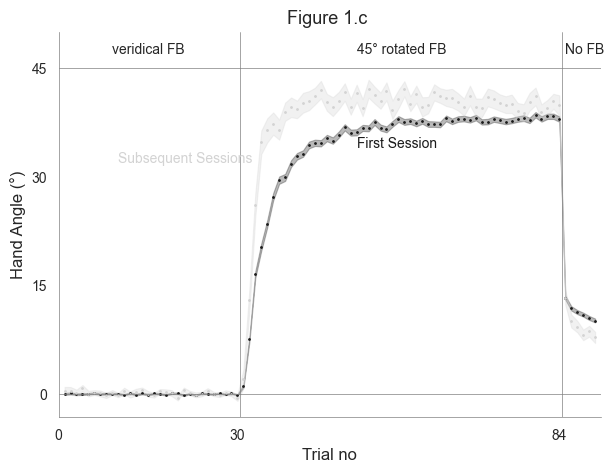

In [483]:
# plot time course of adaptation for first session and subsequent sessions
df_mean_first = (df_first.groupby(
    ['Block','CN'])
    .agg(mean_hand = ('HandFlip', 'median'),
        sem_hand = ('HandFlip', lambda x : np.std(x, ddof = 1)/ np.sqrt(len(x)))) 
    .reset_index())
df_mean_sub = (df_sub.groupby(['Block','CN'])
              .agg(mean_hand = ('HandFlip', 'median'),
                  sem_hand = ('HandFlip', lambda x : np.std(x,ddof = 1) / np.sqrt(len(x))))
              .reset_index())

plt.figure()
plt.plot(df_mean_first['CN'], df_mean_first['mean_hand'],marker='o', linestyle = '',markerfacecolor = 'k', markeredgecolor = 'k')
plt.fill_between(x = df_mean_first['CN'],
                y1 = df_mean_first['mean_hand'] - df_mean_first['sem_hand'],
                y2 = df_mean_first['mean_hand'] + df_mean_first['sem_hand'],
                alpha=0.3, color = 'k')

# plot subsequent sessions
plt.plot(df_mean_sub['CN'], df_mean_sub['mean_hand'],marker='o', linestyle = '',markerfacecolor = 'lightgray', markeredgecolor = 'lightgray')
plt.fill_between(x = df_mean_sub['CN'],
                y1 = df_mean_sub['mean_hand'] - df_mean_sub['sem_hand'],
                y2 = df_mean_sub['mean_hand'] + df_mean_sub['sem_hand'],
                alpha=0.3, color = 'lightgray')

plt.xlabel('Trial no')
plt.ylabel('Hand Angle (°)')
plt.xlim([0,91])
plt.ylim(top = 50)
plt.xticks([0, 30, 84], ['0', '30', '84'])
plt.yticks([0, 15, 30,45], ['0', '15', '30','45'])
plt.axhline(y= 45, linewidth=0.5, color=[0.5,0.5,0.5])
plt.axhline(linewidth=0.5, color=[0.5,0.5,0.5])
plt.axvline(x = 30.5,linewidth=0.5, color=[0.5,0.5,0.5])
plt.axvline(x = 84.5,linewidth=0.5, color=[0.5,0.5,0.5])
plt.text(15, 47, 'veridical FB', fontsize=10, ha='center')
plt.text(57.5, 47, '45° rotated FB', fontsize=10, ha='center')
plt.text(85, 47, 'No FB', fontsize=10, ha='left')

plt.text(10, 32, 'Subsequent Sessions', fontsize=10, color='lightgray',ha='left')
plt.text(50, 34, 'First Session', fontsize=10, color='k',ha='left')

plt.title('Figure 1.c ')
sns.despine(top = True, right = True)
plt.show()

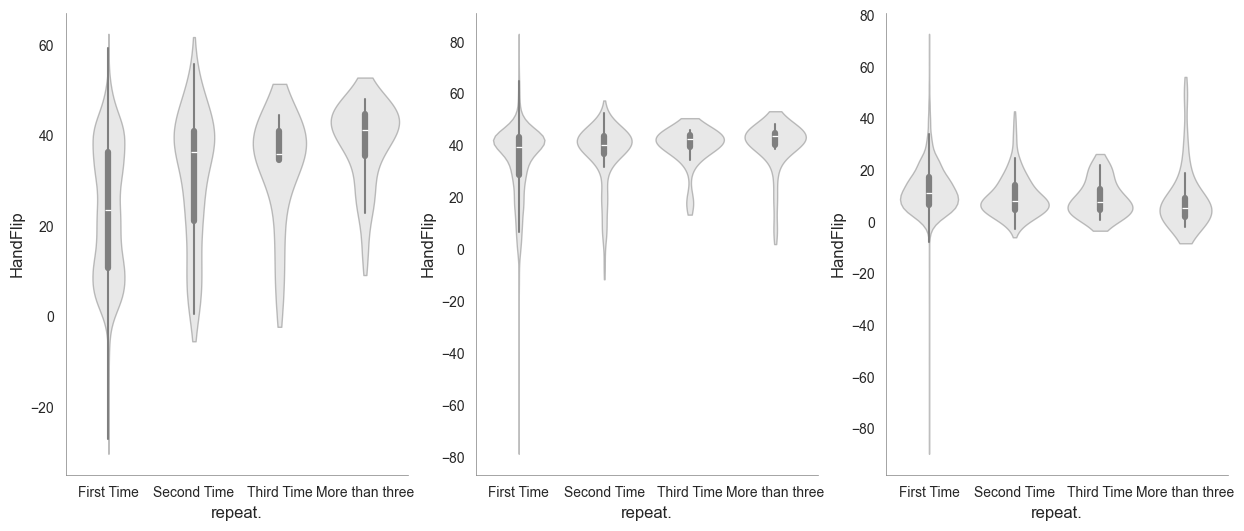

In [270]:
# Fig 2d. Adaptation over sessions
df_mult = df_mult.dropna(subset=['repeat.'])

phases = {
     'early' : {'block': 2, 'trial_range' : (31,40)}, # early adaptation
     'late' : {'block' : 2, 'trial_range' : (74,84) }, # late adaptation
     'aftereffect' : {'block' : 3, 'trial_range' : (85,90)} # aftereffect
}


sessions = ['First Time', 'Second Time', 'Third Time','More than three']

df_sum = []

for i, session in enumerate(sessions):
    for phase, criteria in phases.items():
        #block = criteria['block']
        trial_min, trial_max = criteria['trial_range']
        
        df_tmp = (df_mult[
        (df_mult['repeat.'] == session) & 
        #(df_mult['Block'] == block) & 
        (df_mult['TN'] >= trial_min) &
        (df_mult['TN'] <= trial_max)
                  ]
        .groupby(['Subject.ID', 'repeat.'],sort=False)['HandFlip']
        .median()
        .reset_index()
        .assign(epoch = phase))

        df_sum.append(df_tmp)

df_sum = pd.concat(df_sum, ignore_index=True)
        

fig, axs = plt.subplots(1,3, figsize = (15,6))
for i, phase in enumerate(phases):
    
    sns.violinplot(x = 'repeat.', y = 'HandFlip', data = df_sum[df_sum['epoch'] == phase],
                         color = 'lightgray', inner ='box', cut = 1, alpha = 0.5,ax=axs[i])




In [277]:
# ANCOVA to test for effect of session * phase

df_sum = df_sum.rename(columns={'repeat.': 'repeat'}) 
df_sum['repeat'] = df_sum['repeat'].map({
    'First Time': 1,
    'Second Time': 2,
    'Third Time': 3,
    'More than three': 4
})

model = ols(formula = 'HandFlip ~ repeat * epoch', data = df_sum).fit()
anova_res = anova_lm(model, type = 3)
print(anova_res)
#print(model.summary())

                  df         sum_sq        mean_sq            F        PR(>F)
epoch            2.0  470689.796564  235344.898282  1493.149742  0.000000e+00
repeat           1.0    3771.227055    3771.227055    23.926615  1.028866e-06
repeat:epoch     2.0    8031.687297    4015.843648    25.478589  9.660296e-12
Residual      5582.0  879814.786722     157.616408          NaN           NaN
